In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from glob import glob

import mne
import mne_nirs

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..')
from preprocessing.scripts import argParser
from preprocessing.src import Plots

In [4]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/P-CAT/NIRS_data_clean"
participant_num_len = 5 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

In [5]:
session_dirs = [d for d in glob(study_dir+"/*/*/*fNIRS_DB-DOS", recursive=True) \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [6]:
mne.viz.set_3d_backend('pyvista')
raw_intensities = []

for ses in session_dirs:

#     evts = glob(ses + "/*.evt")
#     if len(evts) != 2:
#         print("There should be 2 evt files. Skipping:", os.path.basename(ses))
#         continue
    try:
        raw_intensities.append(mne.io.read_raw_nirx(ses, verbose=False).load_data(verbose=False))
    except:
        print("Skipping:", ses)
#     raw_intensities[-1].resample(0.7) # downsample to 0.7 HZ to run faster
    
#     # replace raw_ints annotations with events from custom file. 
#     # read events from file
#     events, event_dict = mne.read_events(join(ses, "new_eve.txt"))
#     annot_from_events = mne.annotations_from_events(
#         events=events,
#         event_desc=event_dict,
#         sfreq=raw_intensities[-1].info['sfreq'],
#         orig_time=raw_intensities[-1].info['meas_date'])
    
#     raw_intensities[-1].set_annotations(annot_from_events)

Using pyvistaqt 3d backend.

Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1104/1104_DB-DOS/1104-P_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1104/1104_DB-DOS/1104-C_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1109/1109_DB-DOS/1109-C_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1103/1103_DB-DOS/1103-P_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1103/1103_DB-DOS/1103-C_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1112/1112_DB-DOS/1112-C_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1112/1112_DB-DOS/1112-P_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1102/1102_DB-DOS/1102-P_fNIRS_DB-DOS
Skipping: /data/perlman/moochie/analysis/P-CAT/NIRS_data_clean/1102/1102_DB-DOS/1102-C_fNIRS_DB-DOS


In [7]:
raw_intensities[0]

<RawNIRX | 1126-P_fNIRS_DB-DOS, 20 x 14392 (1842.0 s), ~2.2 MB, data loaded>

In [8]:
len(raw_intensities[0])

14392

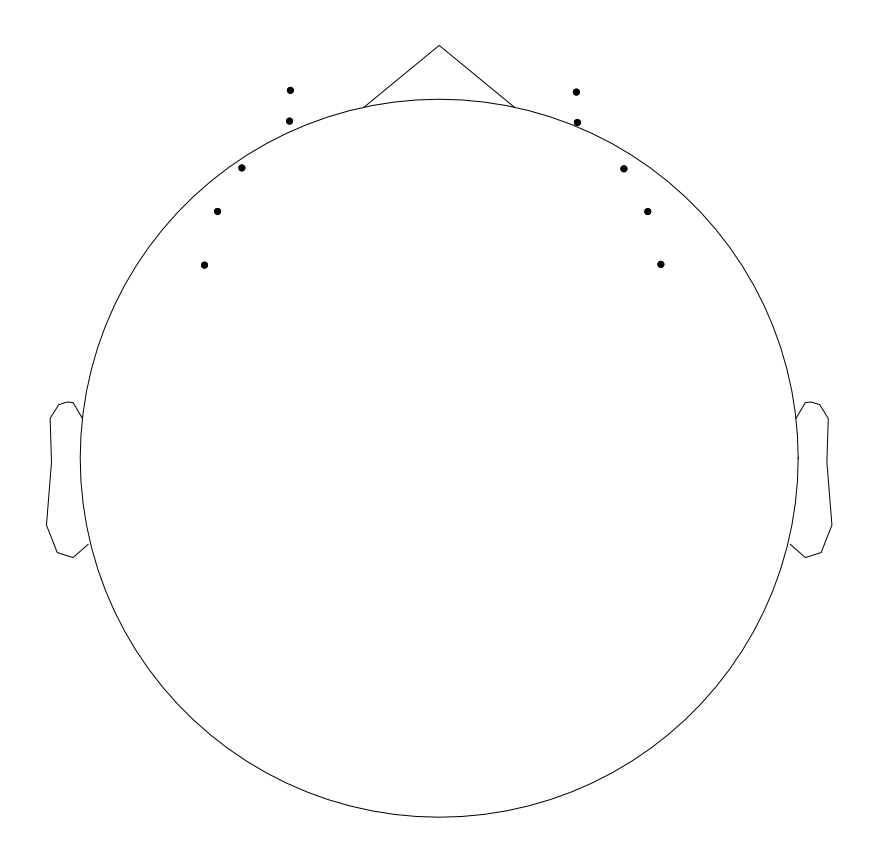

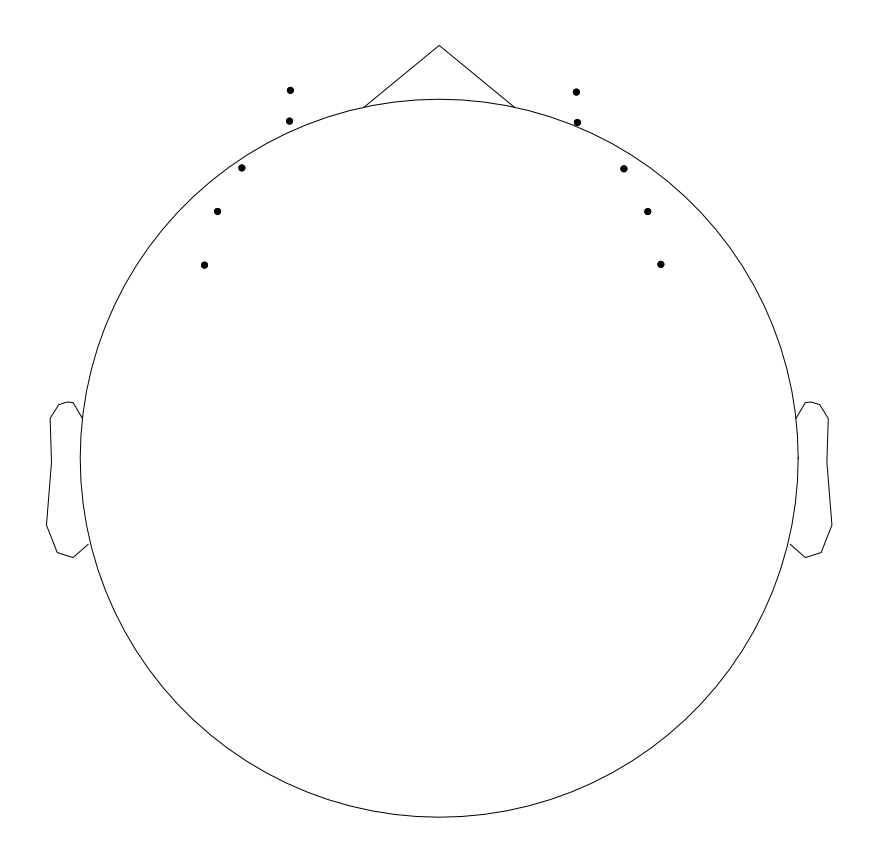

In [9]:
raw_intensities[0].plot_sensors() # viz is screwed up lol

In [10]:
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (
    get_long_channels,
    get_short_channels,
    picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix

# Preprocess NIRS Data

In [14]:
# convert to optical density and motion correct
raw_ods = []
for raw_ints in raw_intensities:
    raw_od = mne.preprocessing.nirs.optical_density(raw_ints)
    corrected_tddr = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od)
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_tddr, ppf=6.)
    
    # we only have long channels, perhaps?
    #short_chs = get_short_channels(raw_haemo)
    long_chs = get_long_channels(raw_haemo)

</usr/local/lib/python3.7/dist-packages/decorator.py:decorator-gen-579>:12: RuntimeWarning: Negative intensities encountered. Setting to abs(x)


In [12]:
len(raw_ints)

14665

In [13]:
long_chs

<RawNIRX | 1116-C_fNIRS_DB-DOS, 16 x 14665 (1877.0 s), ~1.8 MB, data loaded>

# Create design matrix

In [26]:
# design_matrix = make_first_level_design_matrix(
#     raw_haemo,
#     hrf_model='spm',
#     stim_dur=5.0,
#     drift_order=3,
#     drift_model='polynomial')